In [2]:
import os
import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from PIL import Image

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
posters = []

root = os.path.join(os.getcwd(), 'data', 'posters')

for path, subdirs, files in os.walk(root):
    for name in files:
        if name.endswith('.jpg'):
            posters.append(os.path.join(path, name))

print(posters[:2])

['/home/koen/VU/mlproject/data/posters/1990/tt0100212.jpg', '/home/koen/VU/mlproject/data/posters/1990/tt0099582.jpg']


In [7]:
images_info = []
for path in posters:
    with Image.open(path) as img:
        width, height = img.size
        total_pixels = width * height
        images_info.append({'path': path.split('/')[-1], 'pixels': total_pixels})

# Step 4: Create a DataFrame
df_images = pd.DataFrame(images_info)

# Step 5: Sort the DataFrame
df_sorted = df_images.sort_values(by='pixels', ascending=False)

df_sorted.head()

,path,pixels
86,tt0099594.jpg,162600
4897,tt0096156.jpg,162300
670,tt1833673.jpg,159900
927,tt3159708.jpg,159000
7335,tt0283995.jpg,152400


### Preprocess Images

In [3]:
images = [load_img(img_path, target_size=(224, 224)) for img_path in posters]
images = np.array([img_to_array(img) for img in images])
images = preprocess_input(images)

### Feature Extraction

In [ ]:
model = VGG16(weights='imagenet', include_top=False)
features = model.predict(images)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 897s 4s/step


In [ ]:
np.save('extracted_features.npy', features)

In [ ]:
# Load .npy file
features = np.load('extracted_features.npy')

### Dimensionality Reduction

In [ ]:
features_flattened = features.reshape(features.shape[0], -1)
pca = PCA(n_components=0.9)  # Adjust n_components as needed
features_reduced = pca.fit_transform(features_flattened)

### Clustering

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(features_reduced)
clusters = kmeans.labels_

### Plots

In [ ]:
pca_for_plotting = PCA(n_components=2)  # Reduce to 2 for 2D plotting
features_2d = pca_for_plotting.fit_transform(features_reduced)

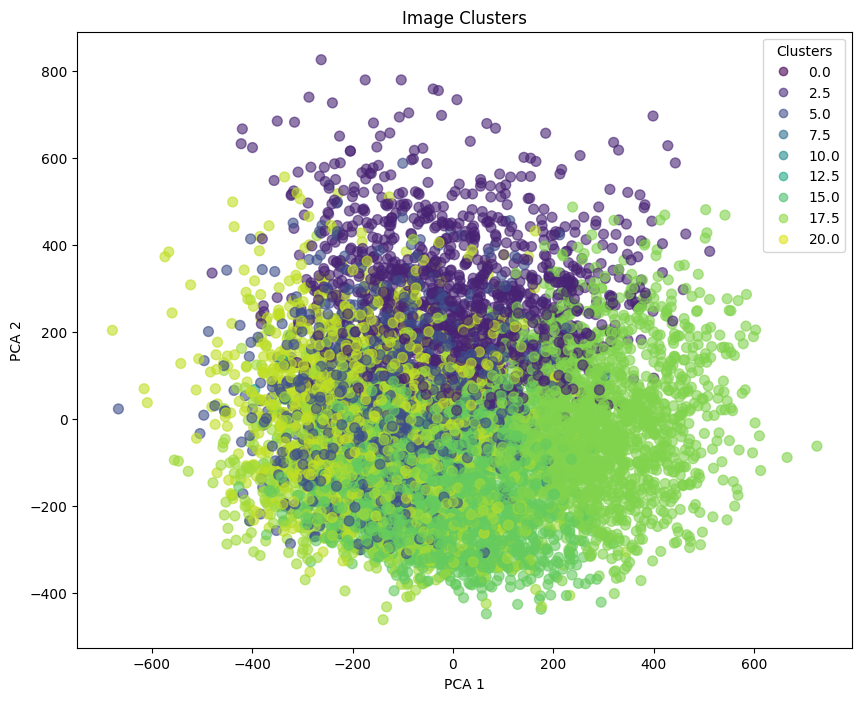

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.6)
plt.title('Image Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Add a legend (optional)
plt.legend(*scatter.legend_elements(), title="Clusters")

plt.show()

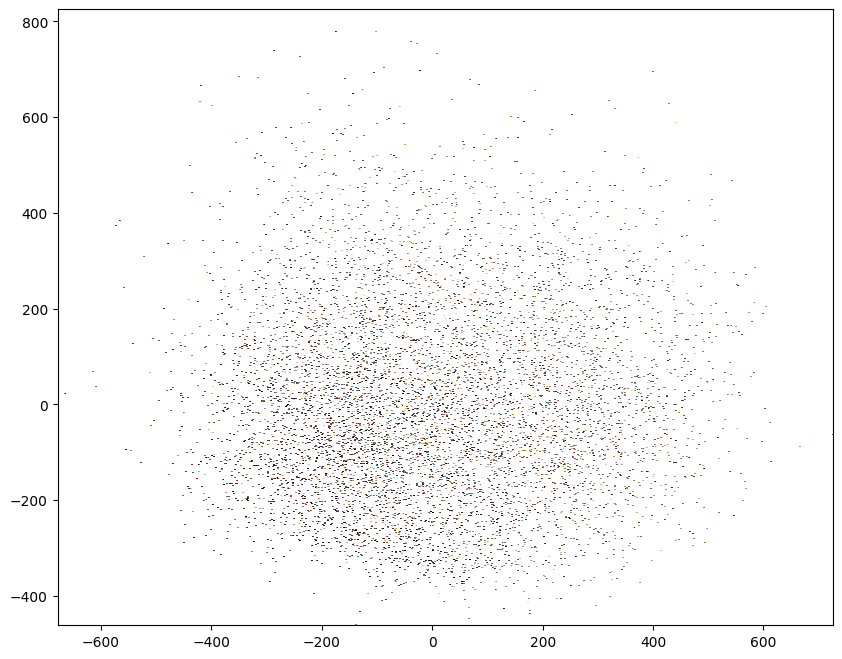

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(features_2d)):
    img = plt.imread(posters[i])  # Load the image
    img = plt.imshow(img, aspect='auto', extent=(features_2d[i, 0]-1, features_2d[i, 0]+1, features_2d[i, 1]-1, features_2d[i, 1]+1))  # Adjust image size and position as needed
    ax.add_artist(img)
ax.set_xlim(features_2d[:, 0].min(), features_2d[:, 0].max())
ax.set_ylim(features_2d[:, 1].min(), features_2d[:, 1].max())
plt.show()

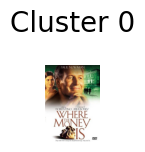

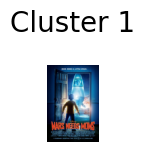

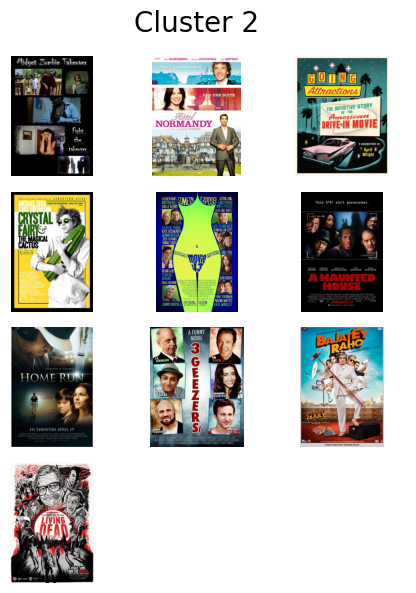

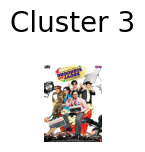

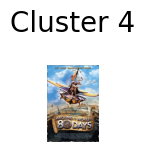

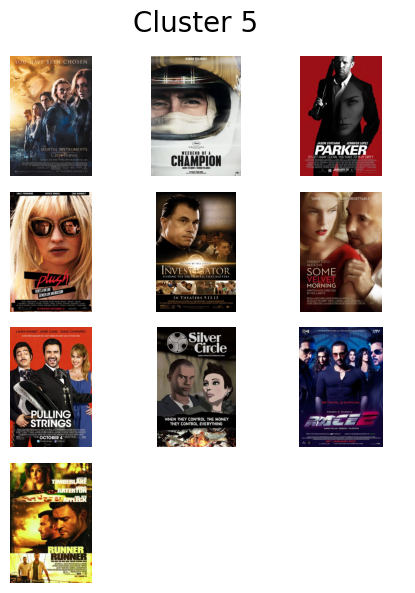

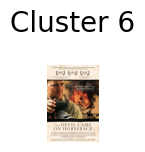

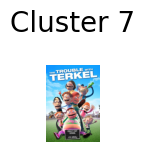

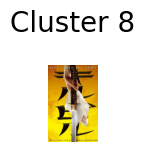

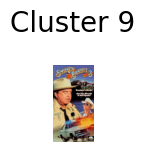

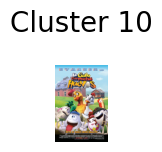

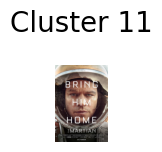

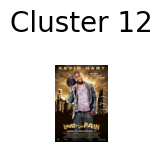

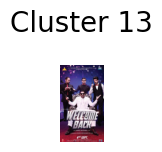

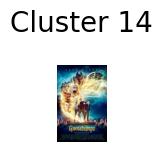

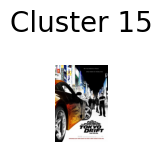

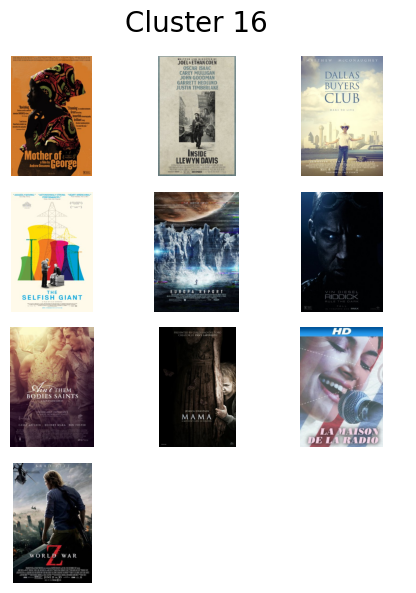

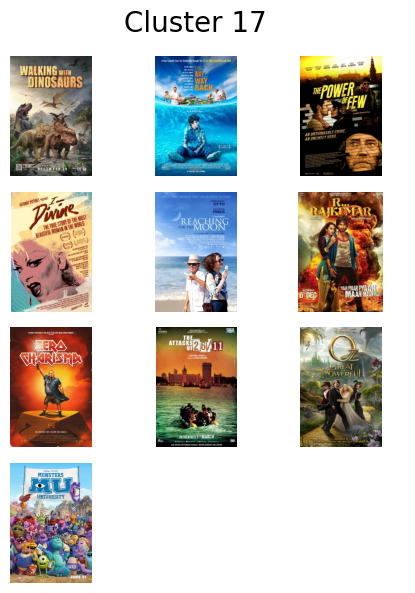

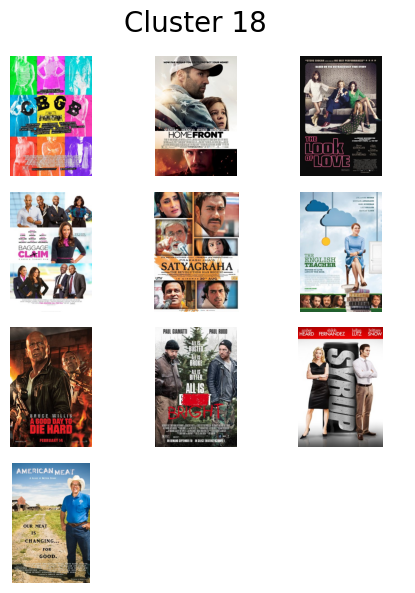

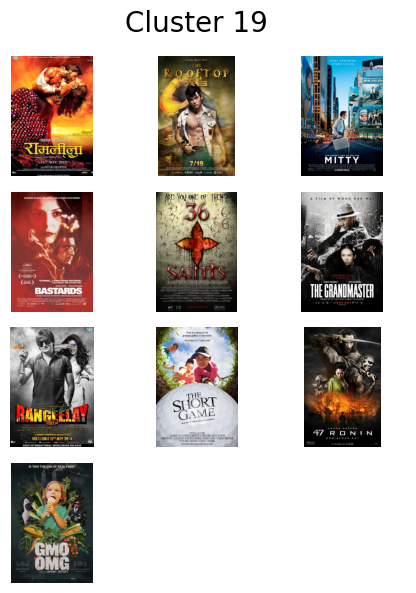

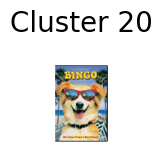

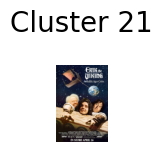

In [ ]:
def display_images_by_cluster_compact(posters, clusters, n_clusters, n_images_per_cluster=10, img_scale=1.5):
    for cluster in range(n_clusters):
        # Find the indexes of images in this cluster
        indexes = [i for i, label in enumerate(clusters) if label == cluster]
        selected_indexes = indexes[:n_images_per_cluster]

        # Calculate grid size
        n = len(selected_indexes)
        cols = int(math.sqrt(n))
        rows = math.ceil(n / cols)

        # Adjust figsize here to make images smaller or larger
        fig, axs = plt.subplots(rows, cols, figsize=(cols * img_scale, rows * img_scale))
        fig.suptitle(f'Cluster {cluster}', fontsize=20)

        # If there's only one image, axs is not an array, handle separately
        if n == 1:
            ax = axs
            img = plt.imread(posters[selected_indexes[0]])
            ax.imshow(img)
            ax.axis('off')
        else:
            for ax, img_index in zip(axs.flat, selected_indexes):
                img = plt.imread(posters[img_index])
                ax.imshow(img)
                ax.axis('off')

            # Hide any unused subplots
            for i in range(n, rows * cols):
                axs.flat[i].axis('off')

        plt.tight_layout()
        plt.show()

display_images_by_cluster_compact(posters, clusters, n_clusters=22)